# DATA620: Project 2

### Homework Team 3: David Simbandumwe, Eric Lehmphul and Lidiia Tronina

In [1]:
import pandas as pd
import networkx as nx
import networkx.algorithms.bipartite as bipartite
import matplotlib as mpl
import matplotlib.pyplot as plt

## Project Objectives

1. Identify a large 2-node network dataset. (Meet the criteria tat it consists of ties between and not within two (or more) distinct groups
2. Reduce the size of te network using a method such as the island method
3. What can you infer about each of the distinct groups?

## Data Source

The dataset that we decided to use for this project is a Facebook-like Forum Network that was obtained from https://toreopsahl.com/datasets/#online_forum_network. This network does not focus on the messages exchanged between user, rather the focus is between users and topics that they partake in. The network can be weighted where the weight is based on the number of messages or characters a user has posted on a particular topic. The two-mode network contains 899 users and 522 topics.

In [2]:
# Read in data

# Weight is by num of characters in messages, not number of messages

# 2 mode: users and topics
weighted_2mode = pd.read_csv('http://opsahl.co.uk/tnet/datasets/OF_longitudinal_weightedchar.txt',
                            sep = ' ',
                            header = None)

weighted_2mode.columns = ["Time", "User", "Topic", "Weight"]
weighted_2mode = weighted_2mode.drop(['Time'], axis = 1)

# 1 mode: users
weighted_1mode = pd.read_csv('http://opsahl.co.uk/tnet/datasets/OF_one-mode_weightedchar_sum.txt',
                            sep = ' ',
                            header = None)

weighted_1mode.columns = ["User_From", "Topic_To", "Weight"]



In [3]:

#weighted_2mode.describe()
#weighted_2mode.shape

In [4]:
weighted_2mode['User'] = 'U' + weighted_2mode['User'].astype(str)
weighted_2mode['Topic'] = 'T' + weighted_2mode['Topic'].astype(str)

In [5]:
weighted_2mode.head(10)

,User,Topic,Weight
0,U201,T3,23
1,U187,T3,63
2,U138,T2,6
3,U345,T3,38
4,U233,T3,60
5,U140,T4,7
6,U307,T3,33
7,U352,T3,12
8,U269,T3,42
9,U187,T5,61


In [6]:
### Load Bipartite Graph

In [7]:
B = nx.Graph()
B.add_nodes_from(weighted_2mode['Topic'], bipartite=0)
B.add_nodes_from(weighted_2mode['User'], bipartite=1)


In [8]:
tuples = [tuple(x) for x in weighted_2mode.to_numpy()]
B.add_weighted_edges_from(tuples, weight='weight')

In [9]:
topic_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
user_nodes = set(B) - topic_nodes

In [10]:
nx.is_connected(B)

False

In [11]:
nx.is_bipartite(B)

True

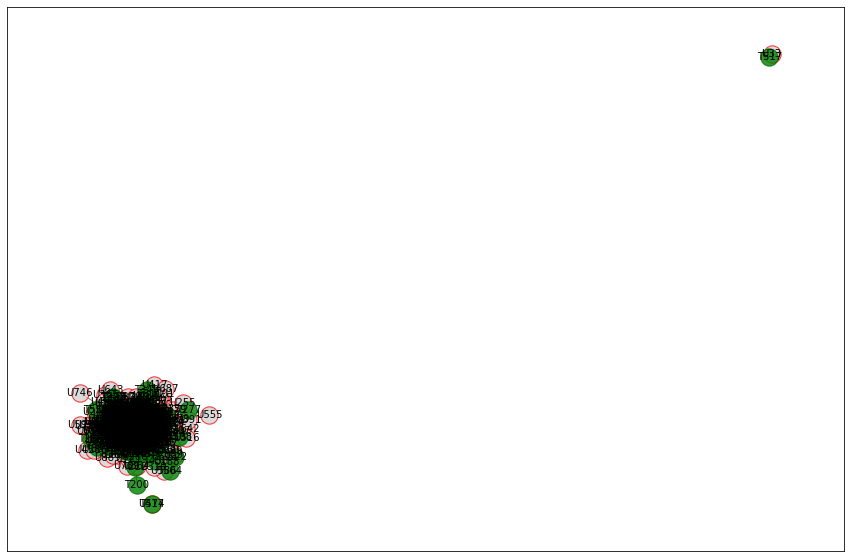

In [12]:
plt.figure(figsize = (15,10))
pos = nx.spring_layout(B)



nx.draw_networkx_nodes(B,pos,
                       nodelist=user_nodes,
                       node_color='lightgray',
                       edgecolors='red',
                       alpha=0.8)
topic = weighted_2mode['Topic']
nx.draw_networkx_nodes(B,pos,
                       nodelist=topic_nodes,
                       node_color='green',
                       edgecolors='darkgreen',
                       alpha=0.8)

nx.draw_networkx_edges(B, pos,
                       edge_color='gray',
                      )


dump = nx.draw_networkx_labels(B, pos, font_size=10)

## Load Graph

## One Mode Projection - Users

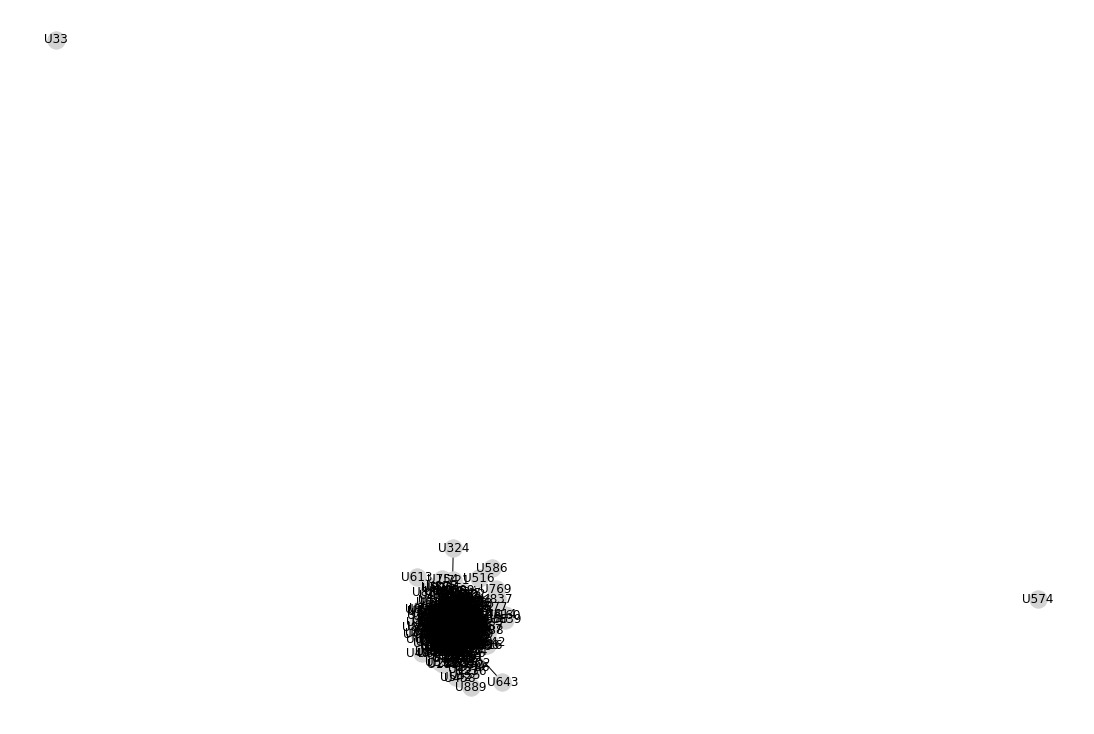

In [13]:
# User subgraph
plt.figure(figsize = (15,10))
# project graph
U = bipartite.weighted_projected_graph(B, user_nodes)

pos_U = nx.spring_layout(U)
weights_U = [edata['weight'] for f,t,edata in U.edges(data=True)]

nx.draw(U, pos = pos_U, 
        with_labels=True, node_color='lightgray',
        font_color='black', font_size=12)

### User Graph Reduction

In [14]:
# method to trim graph by edge weights
def trim_edges(g, weight=1):
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,**edata)
    return g2 

 
# function to find islands
def island_method(g, iterations=5):
    
    weights=[edata['weight'] for f,to,edata in g.edges(data=True)]
 
    mn=int(min(weights))
    mx=int(max(weights))

    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)] 

In [15]:
# retrieve the connected graphs
S = [U.subgraph(c).copy() for c in nx.connected_components(U)][0]
islands=island_method(S)

# create dataframe for results
island_df = pd.DataFrame(columns=['threshold','nodes','islands'])

# add the results of each iteration to the dataframe
for i,r in enumerate(islands):
    island_df.loc[i] = [r[0],len(r[1]),len(list(nx.connected_components(r[1])))]
    
    

    
island_df  
#len(islands)

,threshold,nodes,islands
0,1,659,1
1,7,112,1
2,13,33,3
3,19,9,1
4,25,4,1


In [16]:
# variable for the target weight
filter_weight = 7        
        
filter_U = trim_edges(U,filter_weight)        
        
# add the edge attributes        
edge_labels = nx.get_edge_attributes(filter_U, 'weight')

# generate the weighted data
weights=[edata['weight'] for f,t,edata in U.edges(data=True)]

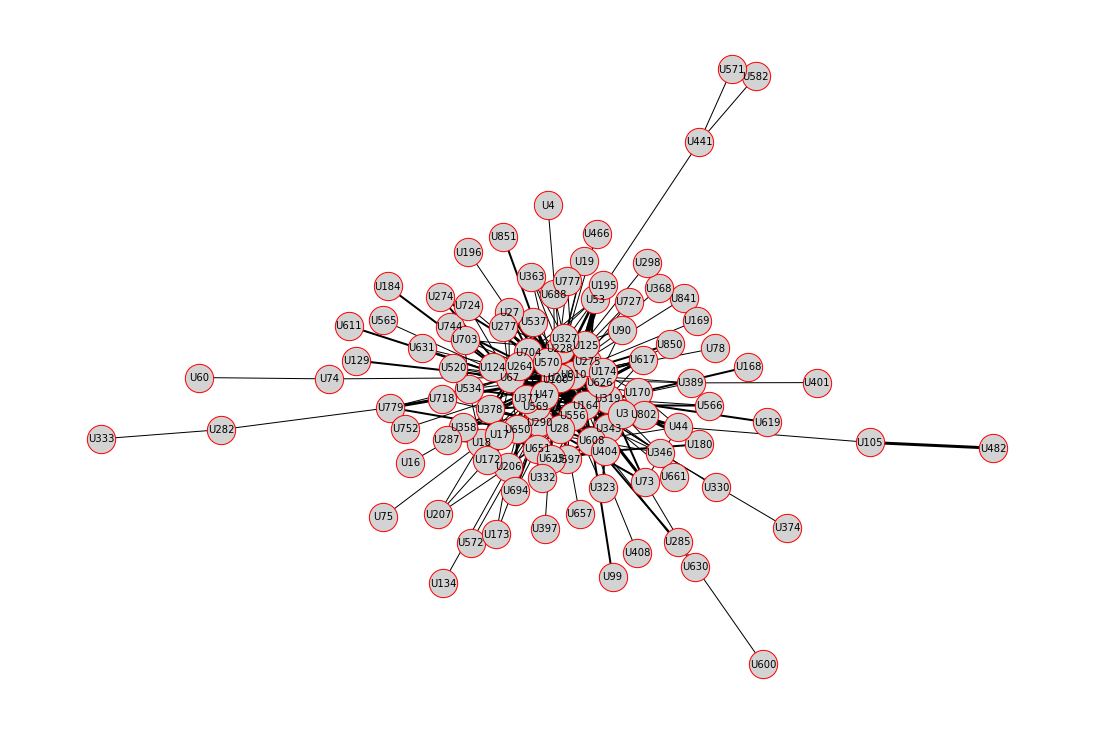

In [17]:
pos_U = nx.spring_layout(filter_U)

# plot the resulting filtered graph
plt.figure(figsize = (15,10))
nx.draw(filter_U, pos=pos_U, 
        with_labels=True, node_size = 800, node_color='lightgray', edgecolors='red',
        font_color='black', font_size=10,
        edge_cmap=mpl.cm.Greys, width=weights, edge_vmin=0, edge_vmax=20)